
The direct colab link to this notebook is [here](https://colab.research.google.com/github/D3Mlab/ppandas/blob/master/experiments/Toronto_Bike_Lanes_CoLab.ipynb).

# Package Imports

In [0]:
!pip install -i https://test.pypi.org/simple/ PPandas==0.0.1.6.9

Looking in indexes: https://test.pypi.org/simple/


In [0]:
!pip install pgmpy==0.1.9
!pip install networkx==2.4
!pip install matplotlib
!pip install python-intervals
!pip install geopandas
!pip install geovoronoi

     |████████████████████████████████| 337kB 3.4MB/s 
     |████████████████████████████████| 931kB 3.3MB/s 
     |████████████████████████████████| 14.7MB 255kB/s 
     |████████████████████████████████| 10.9MB 42.4MB/s 


In [0]:
import pandas as pd
import numpy as np
from ppandas import PDataFrame

# Data Processing

### Toronto Election Study (TES)

Create a DataFrame using the TES dataset columns of age, ward, employment status, birthplace, and bike lane stance. The TES dataset can be found [here](http://www.torontoelectionstudy.com/data).

In [0]:
TES_df  = pd.read_stata('Toronto+Election+Study.dta')[['AGE','CPS5','CPS64','CPS54','CPS36']]
TES_df.head()

,AGE,CPS5,CPS64,CPS54,CPS36
0,68.0,Ward 23 Willowdale (Current Councillor: John F...,Retired,Yes,Oppose policies that will negatively affect dr...
1,65.0,Ward 13 Parkdale-High Park (Current Councillor...,Working for pay full-time,Yes,Create 200km of new bike lanes.
2,65.0,Ward 35 Scarborough Southwest (Current Council...,Retired,Yes,Create 200km of new bike lanes.
3,68.0,Ward 13 Parkdale-High Park (Current Councillor...,Working for pay part-time,No,Create 200km of new bike lanes.
4,49.0,Ward 9 York Centre (Current Councillor: Maria ...,Working for pay full-time,No,Oppose policies that will negatively affect dr...


*   Convert the Age attribute into bins: (17,23], (23,28),...,(63,114]
*   Map values to reduce attribute cardinality and improve readability
*   Rename DataFrame columns and convert them to type string

In [0]:
#Age
age_values = [17,23,28,33,38,43,48,53,58,63,114]
TES_df['AGE'] = pd.cut(TES_df['AGE'],age_values)
TES_df.astype({'AGE': str})

#Ward
TES_df.CPS5 = TES_df['CPS5'].str.replace(r"[\D]",'')
TES_df.rename({'CPS5':'WARD44'},axis=1, inplace=True)
TES_df = TES_df[TES_df['WARD44'] !='']

#Employment status
mapDict = {'Prefer not to say':'Other', 'Working for pay full-time':'Working for pay', 'Unemployed/Looking for work':'Unemployed', 'Working for pay part-time':'Working for pay', 'A student':'Student', 'None of the above':'Other', 'Retired':'Retired', 'Caring for a family full-time':'Family caring'}
TES_df.CPS64=TES_df.CPS64.map(mapDict)
TES_df.rename({'CPS64':'EMPLOYMENT'},axis=1, inplace=True)

#Birthplace
bornDict = {"Prefer not to say/Don't know": "Unknown", "No": "Not Born in Canada","Yes":"Born in Canada"}
TES_df.CPS54=TES_df.CPS54.map(bornDict)
TES_df.rename({'CPS54':'BIRTHPLACE'},axis=1, inplace=True)

#Bike lane stance
mapDict = {'Create 200km of new bike lanes.':'Yes', 'Oppose policies that will negatively affect drivers.':'No', "Don't know":"Not sure"}
TES_df.CPS36=TES_df.CPS36.map(mapDict)
TES_df.rename({'CPS36':'BIKE'},axis=1, inplace=True)

### CBC Vote Compass (VC)

Create a DataFrame using the VC dataset columns of age, ward, employment status, birthplace, and bike lane stance. The VC dataset is not publically available, but the tool used to generate the dataset is [here](https://www.cbc.ca/news2/interactives/votecompass/toronto2014.html)



In [0]:
VC_df = pd.read_csv("vc2014pca_recoded.csv")[['birthyeargroup','ward44','occupation','foreignborn','q14bikelanes']]
VC_df.head()

,birthyeargroup,ward44,occupation,foreignborn,q14bikelanes
0,"(1970,1975]",1,Natural and applied sciences,0.0,5.0
1,"(1985,1990]",1,Student (without other employment),0.0,4.0
2,"(1990,1997]",1,Student (without other employment),0.0,4.0
3,"(1985,1990]",1,Student (without other employment),1.0,4.0
4,"(1985,1990]",1,Management,NaN,4.0


*   Convert the Age attribute into bins: (16,23], (23,28),...,(63,114]
*   Map values to reduce attribute cardinality and improve readability
*   Rename DataFrame columns and convert them to type string

In [0]:
#Age
mapAge = {'(1950,1955]':'(58,63]', '(1955,1960]':'(53,58]', '(1960,1965]':'(48,53]', 
           '(1965,1970]':'(43,48]','(1970,1975]':'(38,43]', '(1975,1980]':'(33,38]', 
           '(1980,1985]':'(28,33]', '(1985,1990]':'(23,28]','(1990,1997]':'(16,23]', 
           '[1900,1950]':'(63,104]', np.nan:'N/A'}
VC_df.birthyeargroup = VC_df.birthyeargroup.map(mapAge)
VC_df.rename({'birthyeargroup':'AGE'},axis=1,inplace=True)
VC_df.dropna(subset=['AGE'],how='all')
VC_df = VC_df[VC_df.AGE !='N/A']

#Ward
VC_df.rename({'ward44':'WARD44'},axis=1,inplace=True)

#Employment status
mapOcc={'Art, culture, recreation and sport':'Working for pay',
        'Business, finance and administration':'Working for pay',
        'Currently not searching for employment':'Unemployed',
        'Currently searching for employment':'Unemployed',
        'Education, law and social, community and government services':'Working for pay',
        'Health':'Working for pay',
        'Management':'Working for pay',
        'Manufacturing and utilities':'Working for pay',
        'Natural and applied sciences':'Working for pay',
        'Natural resources, agriculture and related production':'Working for pay',
        'Retired':'Retired',
        'Sales and service':'Working for pay',
        'Stay-at-home parent':'Family caring',
        'Student (without other employment)':'Student',
        'Trades, transport and equipment operators':'Working for pay',
         np.nan:'Other'}
VC_df.occupation = VC_df.occupation.map(mapOcc)
VC_df.rename({'occupation':'EMPLOYMENT'},axis=1,inplace=True)

#Birthplace
foreign_dict = {0.0:'Born in Canada',1.0:'Not born in Canada',np.nan:'Unknown'}
VC_df['foreignborn'] = VC_df.foreignborn.map(foreign_dict)
VC_df.rename({'foreignborn':'BIRTHPLACE'},axis=1,inplace=True)

#Bike lane stance
mapDict = {1:'No', 2:'No', 3:'Not sure', 4:'Yes', np.nan:'Not sure', 5:'Yes'}
VC_df.q14bikelanes = VC_df.q14bikelanes.map(mapDict)
VC_df.rename({'q14bikelanes':'BIKE'},axis=1,inplace=True)

### Census

Create two dataframes that contain Toronto's census population breakdown by Age bin and by Ward. This data can be found [here](https://open.toronto.ca/dataset/ward-profiles-2014-2018-wards/)

In [0]:
age_marginal_df = pd.read_csv('census2011_age.csv')
print(age_marginal_df)
ward_marginal_df = pd.read_csv('census2011_ward.csv')
print(ward_marginal_df)

         AGE  Unnamed: 1
0    [17,19]    0.042431
1    [20,24]    0.085112
2    [25,29]    0.098280
3    [30,34]    0.093321
4    [35,39]    0.088327
5    [40,44]    0.091572
6    [45,49]    0.096310
7    [50,54]    0.088740
8    [55,59]    0.075400
9    [60,64]    0.065394
10  [65,114]    0.175115
    WARD44  '2011 Census %
0        1        0.023447
1        2        0.021691
2        3        0.019973
3        4        0.020894
4        5        0.024479
5        6        0.022559
6        7        0.019917
7        8        0.019250
8        9        0.017606
9       10        0.024791
10      11        0.023856
11      12        0.020651
12      13        0.020370
13      14        0.020560
14      15        0.023728
15      16        0.020644
16      17        0.019315
17      18        0.017196
18      19        0.021888
19      20        0.029292
20      21        0.018600
21      22        0.025053
22      23        0.033817
23      24        0.023844
24      25        0.02229

# ppandas Analysis

Create TES and VC PDataFrames where the independent nodes of the Bayesian network are age, ward, employment status, and birthplace, and the dependent nodes are the ones not specified as independent nodes, which is bike lane stance

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


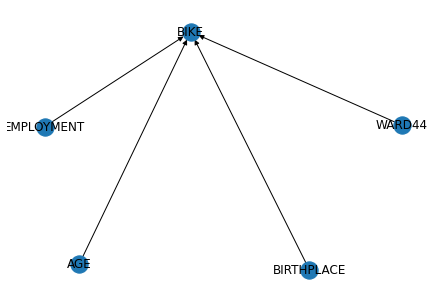

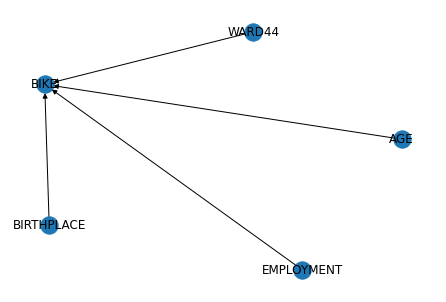

In [0]:
indep_vars = ['AGE','BIRTHPLACE','EMPLOYMENT','WARD44']
all_vars = indep_vars + ['BIKE']
#Create TES PDataFrame
TES_pdf = PDataFrame(independent_vars = indep_vars, data = TES_df[all_vars])
TES_pdf.visualise()
#Create VC PDataFrame
VC_pdf = PDataFrame(indep_vars, VC_df[all_vars])
VC_pdf.visualise()

Perform pjoin where the TES PDataFrame is the reference model and VC PDataFrame is the secondary model. Therefore the "join_pdf" PDataFrame uses the TES marginal distributions for the independent attributes and the conditional probability distribution (CPD) of P(Bike|Age,Ward,Employment,Birthplace) is based on the weighted average of both the TES and VC CPD.

In [0]:
join_pdf = TES_pdf.pjoin(VC_pdf)

Create PDataFrames using the Toronto Census Age and Ward DataFrames. Since these DataFrames are aggregate-level (each row is not an individual sample), use the ".from_populational_data" method and provide the total number of participants in the census using the "num_of_records" argument.

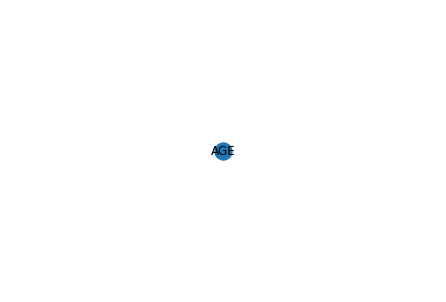

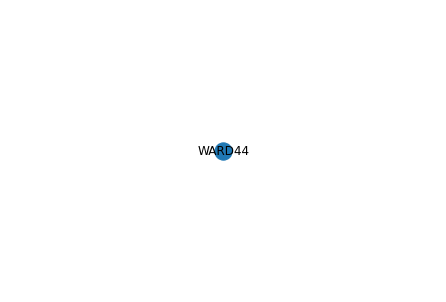

In [0]:
age_marginal_pdf = PDataFrame.from_populational_data(["AGE"],age_marginal_df,2615090)
age_marginal_pdf.visualise()
ward_marginal_pdf = PDataFrame.from_populational_data(["WARD44"],ward_marginal_df,2615090)
ward_marginal_pdf.visualise()

Then replace TES marginal distributions of Age and Ward with the census distributions by performing two pjoins. 

The first pjoin uses "age_marginal_pdf" as the reference model for the independent variable Age. Since there is numerical mismatch between how TES represents Age and how the census represents Age ([17,19],[20,24],...,[65,114]) the "mismatches" argument is used where a dictionary is passed. The dictionary key is the name of the variable exhibiting mismatch and the value is the type of mismatch. To handle this numerical mismatch, a cross product between the two Age representations is computed. Therefore the resulting join_pdf has the census's marginal distribution for Age, the TES's marginal distribution for Ward, and TES's conditional probability distribution P(Vote|Age, Ward,Employment, Birthplace).

The second pjoin uses "ward_marginal_pdf" as the reference model for the independent variable Ward. Therefore the resulting join_pdf has the census's marginal distribution for Age and Ward and the TES's conditional probability distribution P(Vote|Age, Ward, Employment, Birthplace).

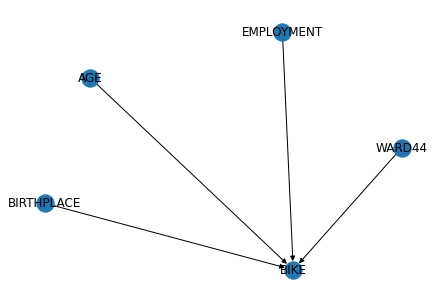

In [0]:
#Replace TES marginal distributions of Age and Ward with census distributions
join_pdf_census = age_marginal_pdf.pjoin(join_pdf,mismatches={"AGE":'numerical'})
join_pdf_census = ward_marginal_pdf.pjoin(join_pdf_census)
join_pdf_census.visualise()

#### Query Results

Can compare the Toronto bike lane stance distributions under a variety of datasets and techniques.

In [0]:
# TES only
print(TES_df['BIKE'].value_counts(normalize=True))

No          0.536585
Yes         0.269686
Not sure    0.193728
Name: BIKE, dtype: float64


In [0]:
# VC only
print(VC_df['BIKE'].value_counts(normalize=True))

Yes         0.794838
Not sure    0.142425
No          0.062736
Name: BIKE, dtype: float64


In [0]:
# Naively stack TES and VC
naive_stack = pd.concat([TES_df.BIKE, VC_df.BIKE], axis=0, ignore_index=True)
print(naive_stack.value_counts(normalize=True))

Yes         0.752927
Not sure    0.146520
No          0.100553
Name: BIKE, dtype: float64


In [0]:
# ppandas TES+VC
queryResults= join_pdf.query(['BIKE'])
print(queryResults)

       BIKE  Probability(BIKE)
0        No           0.191544
1  Not sure           0.216947
2       Yes           0.591509


In [0]:
# ppandas TES+VC+Census
queryResults = join_pdf_census.query(['BIKE'])
print(queryResults)

       BIKE  Probability(BIKE)
0        No           0.217238
1  Not sure           0.256269
2       Yes           0.526493
